# OR Tools for Robot & Drone VRP

- **Map**: 5*5, 10*10, 20*20, 25*25

- **Node**: 20, 40, 60, 80, 100, 120, 140, ...

- 1 depot, 1 drone, 1 robot

- **VRPRD**: VRP -> n * TSP -> Robot -> Drone

##### **目標**

比較 **VRP**、**Drone VR**、**Robot VRP**、**Drone & Robot VRP**，四種組合在不同參數下的表現

##### **表現指標**
- 總路徑時間
- 總路徑長度
- 時間複雜度 (演算法計算時間)
- 空間複雜度 (記憶體使用量) 

##### **參數**
- 不同地圖大小 (5x5, 10x10, 15x15, 20x20, 25x25, 30x30)
- 不同客戶數量 (10, 20, 30, 40, 50, 60, 70, 80, 90, 100)，可以慢慢把 Node 數量增加，客戶數量大於 20 時考慮多台車輛
- 不同車輛數量 (1, 2, 3, 4)
- 蒙地卡羅模擬次數 1000 次

##### **實驗假設**

- 每個客戶點的貨物數量、尺寸皆相同
- 每個客戶點的服務時間皆為 1 分鐘
- 實驗載具共有 Truck、Drone 與 Robot 三種載具
- Drone 與 Robot 可以由 Truck 於任意客戶點中派出與回收，派出與回收各需要花費 1 分鐘
- 若 Truck 抵達回收點時 Drone 與 Robot 尚未返回，需記錄等待時間
- 一台車配置多台 Drone 與 Robot，且 Drone 與 Robot 可以同時在路上
- Truck 載具的速度為 60 km/hr，使用曼哈頓距離計算，載貨量為 **服務點 ÷ 車輛數** (考量平均工作量)
- Drone 載具的速度為 80 km/hr，使用歐式距離計算，每次只能載 1 個貨物, 電池續航力為 60 分鐘
- Robot 載具的速度為 30 km/hr，使用曼哈頓距離計算，每次只能載 4 個貨物, 電池續航力為 120 分鐘

##### **D&RVRP 路徑規劃流程**

1. 選擇分配給 Drone 的服務點

    - 篩選出最近點距離最遠的 n 個點作為 Drone 效益最高的點，**n 設定為第 25 百分位數**
    - 設定其最鄰近點為 Drone 的可能發收站，並排除掉 Node 為其他 Drone 發收站的點

2. 選擇分配給 Robot 的服務點

3. 未分配的點使用 OR-Tools 求解 Truck 路徑

4. 將 Drone 與 Robot 的路徑加入 Truck 路徑中

    - 決定 Drone 的發收站
    - 決定 Robot 的發收站
    - 需考量到最小回收站等待時間

In [1]:
import random as rd
import numpy as np
import pandas as pd
import math
import copy as copy
# OR-Tools
from ortools.constraint_solver import routing_enums_pb2 
from ortools.constraint_solver import pywrapcp 
# 記錄時間/空間複雜度
import time 
import tracemalloc
# 視覺化結果
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Parameters: 實驗參數設定

In [2]:
# [實驗控制變數, 在 Model 中調整] 地圖大小(km) | 服務點數量 | 車輛數量
# MAX_X, MAX_Y = 20, 20
# NUM_NODES = 30
# NUM_VEHICLES = 1

# 配送服務時間
SERVICE_TIME = 1

# [Vehicle]
# 時速 60km | 每台車有最大移動距離(固定) | 貨物重量相同 | 本實驗不考慮車輛成本, 故每台車可載貨物數量 = (站點/車輛數)
VEHICLE_SPEED = 60
VEHICLE_MAX_DISTANCE = 9999999
# VEHICLE_CAPACITIES = int(NUM_NODES / NUM_VEHICLES)

# [Drone]
# 時速 80km | 續航力 60 min | 採用歐幾里德距離 | 負責離群值 | 派出與收回載具各需要 1 分鐘
DRONE_SETUP_TIME = 1  # 發送 & 收回 Drone 的準備時間
DRONE_CAPACITIES = 1
DRONE_SPEED = 80
DRONE_BATTERY_LIFE = 60

# [Robot]
# 時速 30km | 續航力 120 min | 負責高密度點 | 派出與收回載具各需要 1 分鐘
ROBOT_SETUP_TIME = 1
ROBOT_CAPACITIES = 4
ROBOT_SPEED = 30
ROBOT_BATTERY_LIFE = 120

## Model: 資料層設定

In [3]:
# **controls = dict(map_size=(20, 20), num_nodes=20, num_vehicle=1, trials=10)
def create_data_model(**controls):

    NUM_NODES = controls["num_nodes"]
    MAX_X, MAX_Y = controls["map_size"][0], controls["map_size"][1]
    NUM_VEHICLES = controls["num_vehicle"]
    VEHICLE_CAPACITIES = controls["num_nodes"] // controls["num_vehicle"] + 1
    
    data = {}
    data["num_locations"] = [(round(np.random.uniform(0, MAX_X),2), round(np.random.uniform(0, MAX_Y),2)) for i in range(NUM_NODES)]
    data["num_locations"][0] = (round((MAX_X / 2), 2), round((MAX_Y / 2), 2)) 
    data["distance_matrix"] = compute_manhattan_distance_matrix(data["num_locations"]) # 距離矩陣必須為整數, 否則無法在 OR-Tools 中求解
    data["e_distance_matrix"] = compute_euclidean_distance_matrix(data["num_locations"]) # 歐幾里德距離, 取小數第二位(drone 使用)
    data["time_matrix"] = compute_time_matrix(data["distance_matrix"]) # 最小單位分鐘
    data["num_nodes"] = NUM_NODES
    data["num_vehicles"] = NUM_VEHICLES
    data["depot"] = 0 # Depot 的索引值
    data["time_windows"] = []
    data["initial_routes"] = [] # 如果有初始解可以套用
    data["demands"] = [1 for i in range(NUM_NODES)]
    data["demands"][0] = 0
    data["vehicle_capacities"] = [VEHICLE_CAPACITIES for i in range(NUM_VEHICLES)]

    # 三個載具負責的 node 索引值
    data["vehicle"] = []
    data["drone"] = []
    data["robot"] = []    
    return data

def compute_manhattan_distance_matrix(nodes):
    distance_matrix = []
    for node_i in nodes:
        distances = []
        for node_j in nodes:
            if node_i == node_j:
                distances.append(0)
            else:
                manhattan_distance = np.sum(np.abs(np.array(node_i) - np.array(node_j)))
                distances.append(int(manhattan_distance))
        distance_matrix.append(distances)
    return distance_matrix

def compute_euclidean_distance_matrix(nodes):
    distance_matrix = []
    for node_i in nodes:
        distances = []
        for node_j in nodes:
            if node_i == node_j:
                distances.append(0)
            else:
                euclidean_distance = np.sqrt((node_i[0] - node_j[0])**2 + (node_i[1] - node_j[1])**2)
                distances.append(round(euclidean_distance, 2))
        distance_matrix.append(distances)
    return distance_matrix

def compute_time_matrix(distance_matrix):
    time_matrix = []
    for i in distance_matrix:
        time_matrix.append(list(map(lambda x: int(x / VEHICLE_SPEED * 60), i)))
    return time_matrix

# 重置 Node 的貨物需求
def reset_demands(data, **controls):

    NUM_VEHICLES = controls["num_vehicle"]
    VEHICLE_CAPACITIES = int(controls["num_nodes"] / controls["num_vehicle"])
    data["demands"] = [1 for i in range(data["num_nodes"])]
    data["demands"][0] = 0
    data["vehicle_capacities"] = [VEHICLE_CAPACITIES for i in range(NUM_VEHICLES)]
    return data

## Controller: 控制層設定

In [19]:
# 取得目標值(時間和/分鐘): 提供路徑, 速度, 參考距離矩陣, 會考量每個點的服務時間
def get_objective_value(data, route, speed=VEHICLE_SPEED, matrix='distance_matrix'):
    objective_value = 0
    for i in range(len(route) - 1):
        objective_value += data[matrix][route[i]][route[i + 1]] + SERVICE_TIME
    objective_value = int(objective_value / speed * 60)
    return objective_value

# 計算每台車的總等待時間
def get_waiting_time(data, routes, sidekick_routes, name):
    assert name == 'drone' or name == 'robot'
    print(f'\n{name}')
    total = 0
    waiting_time_list = [[] for i in range(len(sidekick_routes))]
    for i, group in enumerate(sidekick_routes):
        for j, r_s in enumerate(group): # 每筆路徑      
            speed_unit = DRONE_SPEED if name == 'drone' else ROBOT_SPEED
            dur_s = get_objective_value(data, r_s, speed_unit, 'e_distance_matrix')
            start, end = r_s[0], r_s[-1]
            r_v = routes[i][routes[i].index(start):routes[i].index(end)+1]
            dur_v = get_objective_value(data, r_v, VEHICLE_SPEED)         
            print(f'Sidekick: {r_s}, Vehicle: {r_v}')
            print(f'-T(s): {dur_s}, T(v): {dur_v}')
            if dur_s > dur_v: # 如果 sidekick 時間比較長, 記錄為等待時間
                print('-Wait for:', (dur_s - dur_v))
                waiting_time_list[i].append(dur_s - dur_v)  
                total += (dur_s - dur_v)
        if waiting_time_list[i] == []:
            waiting_time_list[i] = [0]
    return waiting_time_list

# 計算每台車輛的總服務時間: 目標值 + 等待時間; VRP 問題不會有等待時間
def get_travelling_time(data, routes, drone_waiting=[], robot_waiting=[]):

    total_dist, total_time, total_waiting  = [], [], []

    if len(drone_waiting) > 0 or len(robot_waiting) > 0:
        for index, route in enumerate(routes):
            distance = get_objective_value(data, route)
            duration = distance + np.sum(drone_waiting[index]) + np.sum(robot_waiting[index])
            waiting = np.sum(drone_waiting[index]) + np.sum(robot_waiting[index])
            total_dist.append(distance)
            total_time.append(duration)
            total_waiting.append(waiting)
            print(f'Vehicle {index}: {distance} km, {duration} mins, wait for {waiting} mins')
    else:
        for index, route in enumerate(routes):
            distance = get_objective_value(data, route)
            total_dist.append(distance)
            total_time.append(distance)
            total_waiting.append(0)
            print(f'Vehicle {index}: {distance} km, {distance} mins') 
    print(f'\nTotal distance of all routes: : {np.sum(total_dist)} km')
    print(f'Maximum travel time: {max(total_time)} mins')
    return np.sum(total_dist), max(total_time), np.sum(total_waiting)

def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()}")
    total_distance = 0
    total_load = 0

    for vehicle_id in range(data["num_vehicles"]):
        index = routing.Start(vehicle_id)
        plan_output = f"Route for vehicle {vehicle_id}:\n"
        route_distance = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data["demands"][node_index]
            plan_output += f" {node_index} ({route_distance}) -> "
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id
            )
        plan_output += f" {manager.IndexToNode(index)} ({route_distance})\n"
        plan_output += f"Distance of the route: {route_distance} km\n"
        plan_output += f"Load of the route: {route_load}\n"
        print(plan_output)
        total_distance += route_distance
        total_load += route_load
    
    print(f"Total distance of all routes: {total_distance} km")
    print(f"Total load of all routes: {total_load}")

# Save routes to a list or array
def get_routes(solution, routing, manager):
    """Get vehicle routes from a solution and store them in an array."""
    # Get vehicle routes and store them in a two dimensional array whose
    # i,j entry is the jth location visited by vehicle i along its route.
    routes = []
    for route_nbr in range(routing.vehicles()):
        index = routing.Start(route_nbr)
        route = [manager.IndexToNode(index)]
        while not routing.IsEnd(index):
            index = solution.Value(routing.NextVar(index))
            route.append(manager.IndexToNode(index))
        routes.append(route)
    return routes

# OR Tools = manager + routing + search_parameter = solution
def solve_routing_problem(data):
    ''' 路徑管理員 RoutingIndexManager '''
    # data 中有新資料需於此處引用
    manager = pywrapcp.RoutingIndexManager(
        len(data["distance_matrix"]), data["num_vehicles"], data["depot"]
    )
    ''' 路徑資料 RoutingModel '''
    routing = pywrapcp.RoutingModel(manager)
    # 計算 node 貨物需求的工具
    def demand_callback(from_index):
        from_node = manager.IndexToNode(from_index)
        return data["demands"][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data['vehicle_capacities'],  # vehicle maximum capacities
        True,  # start cumul to zero
        "Capacity",
    )

    # 計算 node 間距離單位的工具, 調整距離計算方法可從函式 return 中修改
    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index) # 取得開始到結束點的索引值
        to_node = manager.IndexToNode(to_index)
        return data["distance_matrix"][from_node][to_node] # 若題目為 VRPTW 需回傳 data["time_matrix"]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback) # 設定所有車輛距離(arc)間的評估單位
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    # routing.SetArcCostEvaluatorOfVehicle() # 打開後可定義其他車輛距離的評估單位

    # 設定車輛行駛中累積的變量, VRPTW 時需將 demension_name 調整為 "Time"
    routing.AddDimension(
        transit_callback_index,
        0,  # 車輛最大等待時間, VRPTW 用
        VEHICLE_MAX_DISTANCE,  # 車輛最大行駛距離
        True,  # 每輛車路線開始時，累計變數是否設為零 (VRPTW 時需調整為 False, 讓時間可累積)
        "Distance",
    )
    distance_dimension = routing.GetDimensionOrDie("Distance")
    # distance_dimension.SetGlobalSpanCostCoefficient(0) # 成本係數設定成 100 會無法跑少數量的車輛路線

    # 設計懲罰項: AddDisjuntion() 只能呼叫一次, 要將 node 排除在路徑中需要調整 Capacity
    penalty = 1000
    for node in range(1, len(data["distance_matrix"])):
        routing.AddDisjunction([manager.NodeToIndex(node)], penalty)

    # 平衡車輛 loading, 避免部分車輛跑有路線
    for vehicle_id in range(data['num_vehicles']):
        routing.SetVehicleUsedWhenEmpty(True, vehicle_id)

    routing.AddConstantDimension(
        1, # +1 for each visit (note start node is counted so unused vehicle is still 1)
        data["num_nodes"] // data["num_vehicles"] + 2, # max visit allowed,  hard limit
        True,  # start cumul to zero
        "Counter")
        
    counter_dimension = routing.GetDimensionOrDie("Counter")
    for vehicle_id in range(manager.GetNumberOfVehicles()):
        index = routing.End(vehicle_id)
        counter_dimension.SetCumulVarSoftLowerBound(index, 2, 100000) # penalty of 100000 for each empty vehicle since counter will be 1 aka (2 - 1) * 100_000  

    ''' 啟發式演算法參數 search_parameters '''
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC # 最快求解法, 預設為 PATH_CHEAPEST_ARC '''
    )
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH     # 開啟後會改用 guided local search 求解 local minimum (GREEDY_DESCENT, TABU_SEARCH, Simulated Annealing...)
    )
    search_parameters.time_limit.seconds = 5 # 搜尋時間限制
    # search_parameters.log_search = True # 開啟後會顯示每次搜尋迭代(log)
    search_parameters.solution_limit = 100 # 解決方案限制
    
    routing.CloseModelWithParameters(search_parameters) # 提供初始解時關閉搜尋參數
    # initial_solution = routing.ReadAssignmentFromRoutes(data["initial_routes"], True) # 求解前如果想提供初始路徑解可打開

    solution = routing.SolveWithParameters(search_parameters) # 將準備好的 search_parameter 提供給 OR Tools 求解
    if solution: # 有找到解的話顯示答案
        routes = get_routes(solution, routing, manager)
        print(f'Routes: {routes}, Length: {len(routes[0])}')
        # print_solution(data, manager, routing, solution)
        return routes
    else:
        print('No solution!')
        return []

# # 提供索引值取得 node 的座標
# def get_nodes(node_list):
#     locations = []
#     for i in node_list:
#         locations.append(data['num_locations'][i])
#     return locations

# 計算角度: 計算 Drone 的返回點, 讓等待最小化
# def calculate_angle(locations):
#     A, B, C = locations[0], locations[1], locations[2]
#     vector_AB = [B[0] - A[0], B[1] - A[1]] # 計算向量 AB 和 BC
#     vector_BC = [C[0] - B[0], C[1] - B[1]]
#     dot_product = vector_AB[0] * vector_BC[0] + vector_AB[1] * vector_BC[1] # 計算向量的點積和模長
#     magnitude_AB = math.sqrt(vector_AB[0]**2 + vector_AB[1]**2)
#     magnitude_BC = math.sqrt(vector_BC[0]**2 + vector_BC[1]**2)
#     angle_radians = math.acos(dot_product / (magnitude_AB * magnitude_BC)) # 計算角度(以弧度為單位)
#     angle_degrees = math.degrees(angle_radians) # 轉換為角度(以度為單位)
#     return round(angle_degrees, 1)

# # 判斷路線方向, 並更新路徑
# def get_direction_by_truck_route(routes, sidekick_routes, name):
#     assert name == 'drone' or name == 'robot'
#     new_routes = sidekick_routes.copy()
#     for i, value in enumerate(sidekick_routes):
#         for j, route in enumerate(value): # 每筆路徑方向
#             start = sidekick_routes[i][j][0]
#             end = sidekick_routes[i][j][-1]          
#             s_index = routes[i].index(start)
#             e_index = routes[i].index(end)
#             if s_index > e_index: # 判斷路徑是否為車輛同行進方向, 如果則改變路徑方向
#                 new_routes[i][j] = new_routes[i][j][::-1]
#     return new_routes

# # 找到每個 node 排除組合中最近的兩個點, 並使用 set() 排除重複點
# def get_closest_nodes(nodes, exclude=[]):
#     neighbors = []
#     for i in nodes:
#         f_dists = []
#         f_indexes = []
#         f_veh = []
#         # 取得 node 與其他點的距離, 使用 exclude 排除掉特定 nodes
#         for index, dist in enumerate(data['distance_matrix'][i]):
#             if (index not in nodes) and (index not in exclude):
#                 f_dists.append(dist)
#                 f_indexes.append(index)
#         neighbors.append(sorted(zip(f_dists, f_indexes))[0][1])
#         neighbors.append(sorted(zip(f_dists, f_indexes))[1][1])
#     return list(set(neighbors))

# # 計算鄰近點的所有可行路徑組合
# def get_robot_route_combination(robot_route, neighbors):
#     solution = []
#     for i in neighbors:
#         for j in neighbors:
#             if i != j:
#                 _route = robot_route.copy()
#                 _route.insert(0, i)
#                 _route.insert(-1, j)
#                 duration = get_objective_value(data, _route, ROBOT_SPEED)
#                 if duration + ROBOT_SETUP_TIME * 2 < ROBOT_BATTERY_LIFE:
#                     solution.append(_route) 
#     return solution

# # 根據車輛路線取得 Robot 路徑
# def get_robot_route():
#     robot_data = []
#     robot_routes = [[] for i in range(len(routes))]
#     excluded_nodes = data['drone'] + [item for sublist in data['robot'] for item in sublist]
#     for group in data['robot']:  
#         neighbors = []
#         for i in group:
#             f_dists, f_indexes = [], []
#             for index, dist in enumerate(data['distance_matrix'][i]):
#                 if index not in excluded_nodes:
#                     f_dists.append(dist)
#                     f_indexes.append(index)
#             sorted_index = [y for x, y in sorted(zip(f_dists, f_indexes))]        
#             count = 0
#             for j in sorted_index:
#                 if count == 3:
#                     break
#                 for veh_i, veh_r in enumerate(routes):
#                     if j in veh_r:
#                         # 找出與 Group 中每個 Node 最近的三個點 (2 個可能會無解)
#                         neighbors.append((j, veh_i))
#                         count += 1
#                     if count == 3:
#                         break
#         # 計算負責車輛
#         points = [0 for i in range(len(routes))]
#         best_neighbors = [[] for i in range(len(routes))]   
#         neighbors = list(set(neighbors))
#         for node in neighbors:
#             points[node[1]] += 1
#             best_neighbors[node[1]].append(node)
#             if max(points) == 2:
#                 assigned_veh = points.index(max(points))    
#         # 排除掉其他車輛的 Node
#         neighbors = [i[0] for i in neighbors if i[1] == assigned_veh]
#         # 找出該車輛路徑中, 鄰近點構成的最佳路徑排列組合
#         if len(neighbors) > 0:
#             combination, time = [], []        
#             for index_j, j in enumerate(neighbors):
#                 for index_k, k in enumerate(neighbors):
#                     if j != k:
#                         r_route = [j]+group+[k]
#                         duration = get_objective_value(data, route=r_route, speed=ROBOT_SPEED)
#                         combination.append(r_route)
#                         time.append(duration)
#             shortest_route = combination[time.index(min(time))]
#             robot_data.append({'name': 'robot', 'node': group, 'route': shortest_route, 'vehicle': assigned_veh, 'duration': min(time), 'neighbors': neighbors})
#             print(f'Group {group} assign to: {assigned_veh};  Route: {shortest_route} ({min(time)})')
#     for obj in robot_data:
#         robot_routes[obj['vehicle']].append(obj['route'])  
#     # 調整 robot 的方向, 使方向與車輛路線一致
#     robot_routes = get_direction_by_truck_route(routes, robot_routes, 'robot')
#     return robot_routes

## View: 畫面顯示

In [5]:
def plot_map(routes, drone_routes=[], robot_routes=[], **controls):
    plt.figure(figsize=(7, 7))
    plt.grid(color='gray', linestyle='-', linewidth=1, alpha=0.2)
    plt.xlim(-1, controls["map_size"][0]+1)
    plt.ylim(-1, controls["map_size"][1]+1) 
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    color_palette = [(0, 0.5, 1), (0.8, 0, 0), (0.0, 0.6, 0.2), (1, 0.7, 0.4)]
    passed_nodes = []

    def draw_line(route, color='gray'):
        arrow_kwargs = dict(length_includes_head=True, head_width=0.5, head_length=1, color=color, alpha=0.8)
        for index, node in enumerate(route):
            if index < len(route) - 1:
                start_loc = data['num_locations'][route[index]]
                end_loc = data['num_locations'][route[index + 1]] 
                plt.arrow(x=start_loc[0], y=start_loc[1], dx=(end_loc[0] - start_loc[0]), dy=(end_loc[1] - start_loc[1]), **arrow_kwargs)
    
    def draw_node(node, color='gray', marker='o'):
        text_kwargs = dict(s=str(node), fontsize=10, color="white", horizontalalignment='center', verticalalignment='center')
        node_kwargs = dict(s=400, color=color, alpha=0.8, edgecolors='black', marker=marker)
        loc = data['num_locations'][node]
        plt.scatter(x=loc[0], y=loc[1], **node_kwargs)
        plt.text(x=loc[0], y=loc[1], **text_kwargs)
        passed_nodes.append(node)

    if len(routes) > 0:
        # Draw VRP solution
        for i_route, route in enumerate(routes):
            RGB_color = color_palette[i_route]
            draw_line(route, RGB_color)
            # Draw vehicle nodes
            for i in route:
                if i != 0:
                    draw_node(node=i, color=RGB_color)
            # Draw drone nodes
            if len(drone_routes) > 0:
                for route in drone_routes[i_route]:
                    drone_color = 'gray'
                    for index, node in enumerate(route):
                        if index != (len(route) - 1):
                            draw_line(route, color=drone_color)
                        if index == 1:
                            draw_node(node, color=drone_color, marker='D')         
            # Draw robot nodes
            if len(robot_routes) > 0:
                for route in robot_routes[i_route]:
                    robot_color = 'gray'
                    for index, node in enumerate(route):
                        if index != (len(route) - 1):
                            draw_line(route)
                        if 0 < index < (len(route) - 1):
                            draw_node(node, color=robot_color, marker='H')
        # Draw un-passed nodes    
        unpassed_nodes = [i for i in range(data["num_nodes"]) if i not in passed_nodes]
        if len(unpassed_nodes) > 0:
            for index in unpassed_nodes:
                draw_node(index)
        # Draw start node
        start_node = data['num_locations'][0]
        plt.scatter(x=start_node[0], y=start_node[1], s=400, color='black', alpha=1, edgecolors='black', marker='s') 
        plt.text(x=start_node[0], y=start_node[1], s='0', fontsize=10, color="white", horizontalalignment='center', verticalalignment='center')
        
    # No route, plot map & nodes
    else:
        if len(data['num_locations']) > 0:
            for index, node in enumerate(data['num_locations']):
                text_kwargs = dict(s=str(index), fontsize=10, color="white", horizontalalignment='center', verticalalignment='center')
                node_kwargs = dict(s=400, color='gray', alpha=0.8, edgecolors='black')
                if index == 0: 
                    plt.scatter(x=node[0], y=node[1], s=400, color='black', alpha=0.8, edgecolors='black', marker='s') 
                    plt.text(x=node[0], y=node[1], s='0', fontsize=10, color="white", horizontalalignment='center', verticalalignment='center')
                    continue
                plt.scatter(x=node[0], y=node[1], **node_kwargs)
                plt.text(x=node[0], y=node[1], **text_kwargs)
        else:
            print("No data to plot.")

# 畫出分群結果
def plot_cluster(labels):
    unique_labels = set(labels)
    if len(unique_labels) == 1:
        print('Failed clustering!')
    else:
        color_labels = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
        colors = [color_labels[label - 1] for label in labels] # combine labes and colors

        for node, label, color in zip(data['num_locations'], labels, colors):
            if label == -1: # Black used for noise.
                color = [0, 0, 0, 1]
            plt.scatter(x=node[0], y=node[1], s=400, color=color, alpha=0.8, edgecolors='black') 
            plt.text(x=node[0], y=node[1], s=str(data['num_locations'].index(node)), fontsize=10, color="white", horizontalalignment='center', verticalalignment='center')
        plt.show()

## VRP 解題方法說明

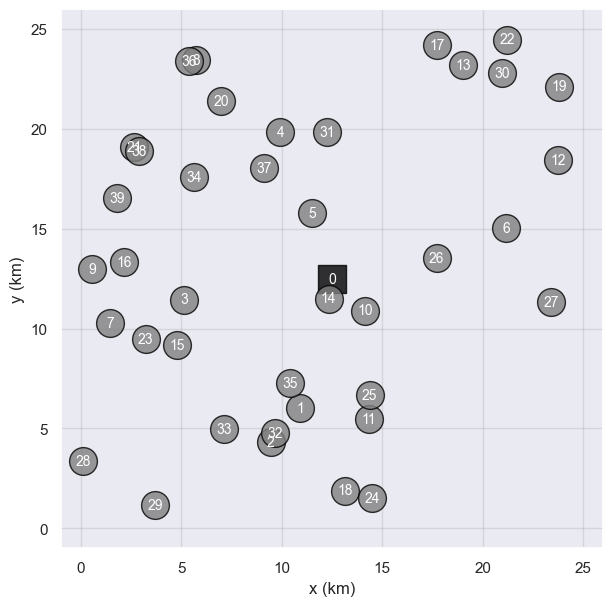

In [6]:
# Set data & control parameter
controls = dict(map_size=(25, 25), num_nodes=40, num_vehicle=2)
data = create_data_model(**controls)

plot_map(routes=[], **controls)

In [7]:
pd.json_normalize(data)

,num_locations,distance_matrix,e_distance_matrix,time_matrix,num_nodes,num_vehicles,depot,time_windows,initial_routes,demands,vehicle_capacities,vehicle,drone,robot
0,"[(12.5, 12.5), (10.91, 6.02), (9.46, 4.32), (5...","[[0, 8, 11, 8, 9, 4, 11, 13, 17, 12, 3, 8, 17,...","[[0, 6.67, 8.73, 7.43, 7.78, 3.45, 9.03, 11.27...","[[0, 8, 11, 8, 9, 4, 11, 13, 17, 12, 3, 8, 17,...",40,2,0,[],[],"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[21, 21]",[],[],[]


### VRP

Routes: [[0, 10, 25, 11, 24, 18, 29, 28, 7, 9, 16, 3, 23, 15, 33, 2, 32, 1, 35, 14, 0], [0, 26, 6, 27, 12, 19, 30, 22, 13, 17, 8, 36, 20, 38, 21, 39, 34, 37, 4, 31, 5, 0]], Length: 21


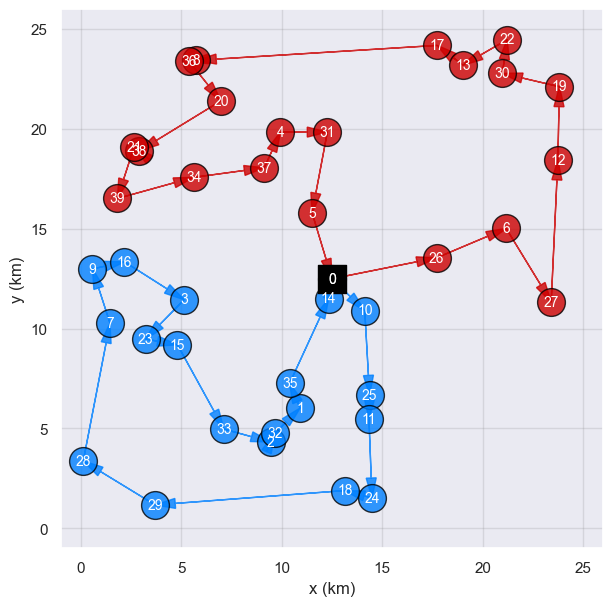

In [8]:
VRP_result = solve_routing_problem(data)
plot_map(routes=VRP_result, **controls)

### VRP + Drone

1. 解 VRP
2. 決定 Drone Node
3. 在原路線中移除 Drone Node

In [9]:
'''
[Drone Node 的挑選規則]
- 距離計算單位採歐幾里德距離
- 每台 Truck 只有一台 Drone
- 以 OR-Tools 初始解分組, 找出每組中最適合派給 Drone 的點
- 篩選出最近點距離最遠的 n 個點作為 Drone 效益最高的點, n 設定為 25 百分位數
- 設定其原路徑為 Drone 的可能發收站, 並排除掉 Node 為其他 Drone 發收站的點
'''

def select_drone_nodes(data, routes):

    # 找出最近距離 Node 排序
    nearest_dists = []
    for i in data['e_distance_matrix']:
        sorted_i = sorted(i)
        nearest_dists.append(sorted_i[1])
    sorted_nearest_indexes = np.argsort(nearest_dists).tolist()[::-1]
    sorted_nearest_indexes = sorted_nearest_indexes[:int(data["num_nodes"])] 
    sorted_nearest_indexes.remove(0)

    # 將 Node 分配到初始解車輛路徑中
    drone_nodes = [[] for i in range(len(routes))]
    for i, route in enumerate(routes):
        for j in sorted_nearest_indexes:
            drone_nodes[i].append(j) if j in route else None
        drone_nodes[i] = drone_nodes[i][:int(len(route)/4)] # 根據中位數篩選出前 25% 最遠的點

    # 取得 Drone 的合適路徑, 原路徑鄰的點不能為其他 Drone 點
    drone_routes = [[] for i in range(len(routes))]
    for i, group in enumerate(drone_nodes):
        exclusion = []
        for n in group:
            if n not in exclusion:
                start, end = routes[i].index(n)-1, routes[i].index(n)+1
                exclusion.append(routes[i][start])
                exclusion.append(routes[i][end])
                route = [routes[i][start], n, routes[i][end]]
                drone_routes[i].append(route)                   

    print('Drone Routes:', drone_routes)
    return drone_routes

Routes: [[0, 32, 21, 29, 5, 9, 36, 11, 25, 19, 16, 24, 20, 39, 15, 12, 1, 13, 4, 37, 7, 0], [0, 22, 28, 30, 6, 17, 34, 26, 3, 35, 8, 10, 23, 14, 27, 38, 2, 18, 31, 33, 0]], Length: 22
Drone Routes: [[[19, 16, 24], [11, 25, 19], [4, 37, 7]], [[17, 34, 26], [22, 28, 30], [27, 38, 2]]]
[[[19, 16, 24], [11, 25, 19], [4, 37, 7]], [[17, 34, 26], [22, 28, 30], [27, 38, 2]]]

drone
Sidekick: [19, 16, 24], Vehicle: [19, 24]
-T(s): 10, T(v): 8
-Wait for: 2
Sidekick: [11, 25, 19], Vehicle: [11, 19]
-T(s): 9, T(v): 6
-Wait for: 3
Sidekick: [4, 37, 7], Vehicle: [4, 7]
-T(s): 6, T(v): 8
Sidekick: [17, 34, 26], Vehicle: [17, 26]
-T(s): 11, T(v): 10
-Wait for: 1
Sidekick: [22, 28, 30], Vehicle: [22, 30]
-T(s): 7, T(v): 10
Sidekick: [27, 38, 2], Vehicle: [27, 2]
-T(s): 7, T(v): 11
[[2, 3], [1]]


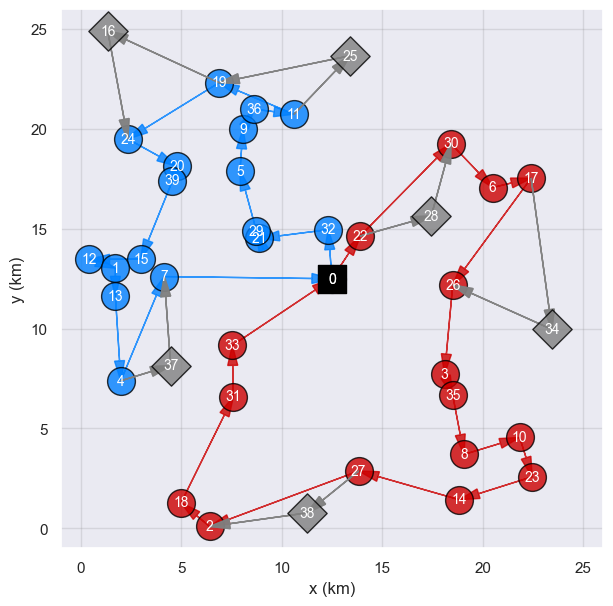

In [10]:
# 解 VRP -> 分開挑 Drone 點 -> 連接路線
data = create_data_model(**controls)
routes = solve_routing_problem(data)
drone_routes = select_drone_nodes(data, routes)
print(drone_routes)
# 調整車輛路線
for index, group in enumerate(drone_routes):
    for r in group:
        routes[index].remove(r[1])

drone_waiting = get_waiting_time(data, routes, drone_routes, 'drone')
print(drone_waiting)

plot_map(routes=routes,drone_routes=drone_routes, robot_routes=[], **controls)

### VRP + Robot

1. 解 VRP
2. 決定 Robot Node
3. 設定 Time Window
4. 解 VRPTW

In [67]:
'''
[Robot Node 挑選規則]
- 每個  Truck 只有一輛 Robot
- 從 Initial Solution 中抓出最短的路徑組合 (6 個造訪點一組)
- 路徑組合的造訪時間不可超過 Robot 電池續航力
- 根據距離排序, 排除掉 Node 重複的組合
- 篩選出前 25 百分位數近的組合
'''

def select_robot_nodes(data, routes):

    robot_routes = [[] for i in range(len(routes))]
    for index, route in enumerate(routes):
        # print('Choosing the nodes for Robot:', route)
        route_filter = []
        for j in range(len(route)):
            if j <= (len(route) - ROBOT_CAPACITIES - 2):
                robot_route = route[j:j + ROBOT_CAPACITIES + 2]            
                r_dur = get_objective_value(data, robot_route, ROBOT_SPEED)
                if r_dur <= ROBOT_BATTERY_LIFE: # 排除超過電池續航力(ROBOT_BATTERY_LIFE)的路徑組合
                    # print(f'Route {j}: {robot_route}, Duratoin: {r_dur}')
                    route_filter.append({ 'route': robot_route, 'duration': r_dur })        
        # 根據最短時間(duration)排序, 並排除掉重複 Node 的路徑組合
        route_filter.sort(key=lambda x: x['duration'])
        route_filter = route_filter[:int(len(route_filter)/4)] # 保留 25% 路徑組合
        best_routes = [route_filter[0]['route']]
        for r_dict in route_filter:
            overlap = 0
            for best_r in best_routes:
                if len(set(best_r) & set(r_dict['route'])) > 0:
                    overlap += 1
                    break
            if overlap == 0:
                best_routes.append(r_dict['route'])
        robot_routes[index] = best_routes
    print('Robot Routes:', robot_routes)
    return robot_routes

In [75]:
data = create_data_model(**controls)
routes = solve_routing_problem(data)
robot_routes = select_robot_nodes(data, routes)
# 調整車輛路線
for index, route in enumerate(routes):
    exclude_nodes = [item for sublist in robot_routes[index] for item in sublist if 0 < sublist.index(item) < len(sublist) - 1]
    routes[index] = [i for i in route if i not in exclude_nodes]
# 設定 Initial Solution 作為第二階段 VRP 求解用
data["initial_routes"] = routes

Routes: [[0, 8, 35, 24, 15, 25, 37, 22, 3, 13, 23, 29, 36, 6, 27, 1, 16, 30, 39, 0], [0, 18, 32, 2, 33, 31, 4, 9, 34, 38, 7, 12, 17, 10, 20, 11, 21, 14, 19, 5, 28, 26, 0]], Length: 20
Robot Routes: [[[36, 6, 27, 1, 16, 30]], [[18, 32, 2, 33, 31, 4]]]


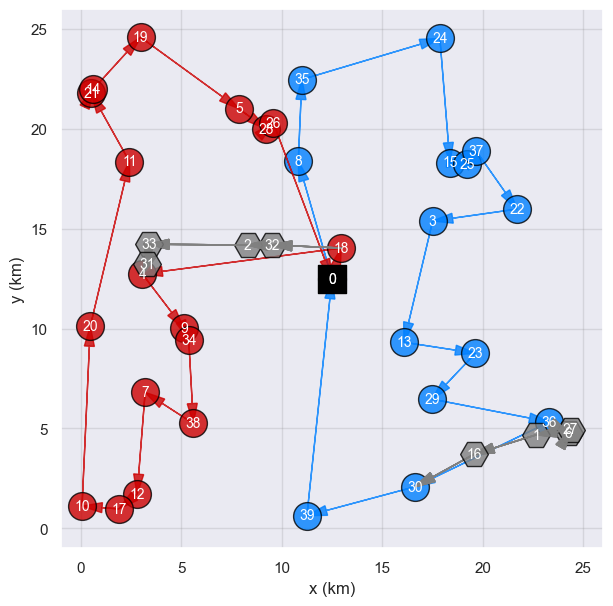

In [76]:
plot_map(routes=routes,robot_routes=robot_routes, **controls)

In [78]:
# Set Time Window for VRPTW
robot_durs = [[] for i in range(len(routes))]

data["time_windows"] = [(0, 640) for i in range(data["num_nodes"])]

temp_constraint = {
    'nodes': [],
    'min_travel': [],
    'vehicle': []
}

for index, group in enumerate(robot_routes):
    print('Vehicle', index)
    for r_route in group:
        r_dur = get_objective_value(data, r_route, ROBOT_SPEED) # 取得 robot_routes 中每個組合的時間
        print('Robot Route:', r_route, ', Duration:', r_dur)
        robot_durs[index].append(r_dur)
        for node in r_route:
            if 0 < r_route.index(node) < len(r_route) - 1:
                data['demands'][node] = 999  # 將指定點的需求設置為 999
                data["vehicle_capacities"][index] -= 1  # 修正該 node 負責車輛的容量         
            # 頭尾設定 Time Windows (車輛不能等待超過 10 分鐘)          
            elif r_route.index(node) == 0:
                cumul_time = get_objective_value(data, routes[index][:routes[index].index(node)+1])
                node_tw = (cumul_time, cumul_time)
                data["time_windows"][node] = node_tw
                print('- Node', node, node_tw)
            elif r_route.index(node) == len(r_route) - 1:
                node_tw = (cumul_time + r_dur, cumul_time + r_dur + 10)
                data["time_windows"][node] = node_tw
                print('- Node', node, node_tw)
        temp_constraint['nodes'].append((r_route[0], r_route[-1]))
        temp_constraint['min_travel'].append(r_dur)
        temp_constraint['vehicle'].append(index)

print(temp_constraint)

Vehicle 0
Robot Route: [36, 6, 27, 1, 16, 30] , Duration: 30
- Node 36 (67, 67)
- Node 30 (97, 107)
Vehicle 1
Robot Route: [18, 32, 2, 33, 31, 4] , Duration: 28
- Node 18 (3, 3)
- Node 4 (31, 41)
{'nodes': [(36, 30), (18, 4)], 'min_travel': [30, 28], 'vehicle': [0, 1]}


In [79]:
def print_vrptw_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()}")
    time_dimension = routing.GetDimensionOrDie("Time")
    total_time = 0
    for vehicle_id in range(data["num_vehicles"]):
        index = routing.Start(vehicle_id)
        plan_output = f"Route for vehicle {vehicle_id}:\n"
        while not routing.IsEnd(index):
            time_var = time_dimension.CumulVar(index)
            plan_output += (
                f"{manager.IndexToNode(index)}"
                f" Time({solution.Min(time_var)},{solution.Max(time_var)})"
                " -> "
            )
            index = solution.Value(routing.NextVar(index))
        time_var = time_dimension.CumulVar(index)
        plan_output += (
            f"{manager.IndexToNode(index)}"
            f" Time({solution.Min(time_var)},{solution.Max(time_var)})\n"
        )
        plan_output += f"Time of the route: {solution.Min(time_var)}min\n"
        print(plan_output)
        total_time += solution.Min(time_var)
    print(f"Total time of all routes: {total_time}min")

def solve_vrptw(data, temp_constraint={}):
    """Solve the VRP with time windows."""
    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(
        len(data["time_matrix"]), data["num_vehicles"], data["depot"]
    )
    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)

    # Create a demand callback.
    def demand_callback(from_index):
        from_node = manager.IndexToNode(from_index)
        return data["demands"][from_node]
    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data['vehicle_capacities'],  # vehicle maximum capacities
        True,  # start cumul to zero
        "Capacity",
    )

    # Create and register a transit callback.
    def time_callback(from_index, to_index):
        """Returns the travel time between the two nodes."""
        # Convert from routing variable Index to time matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["time_matrix"][from_node][to_node]
    transit_callback_index = routing.RegisterTransitCallback(time_callback)
    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    # Add Time Windows constraint.
    time = "Time"
    routing.AddDimension(
        transit_callback_index,
        10,  # allow waiting time
        640,  # maximum time per vehicle
        False,  # Don't force start cumul to zero.
        time,
    )
    time_dimension = routing.GetDimensionOrDie(time)

    # Add time window constraints for each location except depot.
    for location_idx, time_window in enumerate(data["time_windows"]):
        if location_idx == data["depot"]:
            continue
        index = manager.NodeToIndex(location_idx)
        time_dimension.CumulVar(index).SetRange(time_window[0], time_window[1])
    # Add time window constraints for each vehicle start node.
    depot_idx = data["depot"]
    for vehicle_id in range(data["num_vehicles"]):
        index = routing.Start(vehicle_id)
        time_dimension.CumulVar(index).SetRange(
            data["time_windows"][depot_idx][0], data["time_windows"][depot_idx][1]
        )
    # Instantiate route start and end times to produce feasible times.
    for i in range(data["num_vehicles"]):
        routing.AddVariableMinimizedByFinalizer(
            time_dimension.CumulVar(routing.Start(i))
        )
        routing.AddVariableMinimizedByFinalizer(time_dimension.CumulVar(routing.End(i)))
    
    '''
    設計其他 Time Windows 條件, 讓 VRPTW 能找到更好的解
    (1) 等待時間過長
    (2) 收發點會分配給不同車輛
    '''
    for index, nodes in enumerate(temp_constraint['nodes']):
        routing.SetAllowedVehiclesForIndex([temp_constraint['vehicle'][index]], nodes[0])
        routing.SetAllowedVehiclesForIndex([temp_constraint['vehicle'][index]], nodes[1])

    # 設計懲罰項: AddDisjuntion() 只能呼叫一次, 要將 node 排除在路徑中需要調整 Capacity
    penalty = 1000
    for node in range(1, len(data["time_matrix"])):
        routing.AddDisjunction([manager.NodeToIndex(node)], penalty)

    # 平衡車輛 loading, 避免部分車輛不出發跑路線
    for vehicle_id in range(data['num_vehicles']):
        routing.SetVehicleUsedWhenEmpty(True, vehicle_id)
    routing.AddConstantDimension(
        1, # +1 for each visit (note start node is counted so unused vehicle is still 1)
        data["num_nodes"] // data["num_vehicles"] + 2, # max visit allowed,  hard limit
        True,  # start cumul to zero
        "Counter")
    counter_dimension = routing.GetDimensionOrDie("Counter")
    for vehicle_id in range(manager.GetNumberOfVehicles()):
        index = routing.End(vehicle_id)
        counter_dimension.SetCumulVarSoftLowerBound(index, 2, 100000) # penalty of 100000 for each empty vehicle since counter will be 1 aka (2 - 1) * 100_000  

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )
    search_parameters.solution_limit = 100
    search_parameters.time_limit.seconds = 5

    # Solve the problem & print solution.
    solution = routing.SolveWithParameters(search_parameters)
    if solution:
        vrptw_routes = get_routes(solution, routing, manager)
        print_vrptw_solution(data, manager, routing, solution)
        return vrptw_routes
    else:
        print('No solution.')

In [80]:
# 計算每台車的總等待時間
def get_waiting_time(data, routes, sidekick_routes, name):
    assert name == 'drone' or name == 'robot'
    print(f'\n{name}')
    total = 0
    waiting_time_list = [[] for i in range(len(sidekick_routes))]
    for i, group in enumerate(sidekick_routes):
        for j, r_s in enumerate(group): # 每筆路徑  
            print(r_s)    
            speed_unit = DRONE_SPEED if name == 'drone' else ROBOT_SPEED
            dur_s = get_objective_value(data, r_s, speed_unit, 'e_distance_matrix')
            start, end = r_s[0], r_s[-1]
            r_v = routes[i][routes[i].index(start):routes[i].index(end)+1]
            dur_v = get_objective_value(data, r_v, VEHICLE_SPEED)         
            print(f'Sidekick: {r_s}, Vehicle: {r_v}')
            print(f'-T(s): {dur_s}, T(v): {dur_v}')
            if dur_s > dur_v: # 如果 sidekick 時間比較長, 記錄為等待時間
                print('-Wait for:', (dur_s - dur_v))
                waiting_time_list[i].append(dur_s - dur_v)  
                total += (dur_s - dur_v)
        if waiting_time_list[i] == []:
            waiting_time_list[i] = [0]
    return waiting_time_list

In [73]:
vrptw_routes = solve_vrptw(data, temp_constraint)
if vrptw_routes:
    robot_waiting = get_waiting_time(data, vrptw_routes, robot_routes, 'robot')

Objective: 8153
Route for vehicle 0:
0 Time(0,0) -> 14 Time(7,7) -> 1 Time(11,21) -> 17 Time(17,36) -> 22 Time(24,43) -> 12 Time(34,44) -> 33 Time(49,49) -> 27 Time(53,53) -> 2 Time(58,58) -> 25 Time(63,63) -> 35 Time(69,69) -> 10 Time(69,69) -> 21 Time(81,81) -> 39 Time(85,85) -> 18 Time(92,92) -> 0 Time(100,100)
Time of the route: 100min

Route for vehicle 1:
0 Time(0,0) -> 5 Time(3,10) -> 34 Time(12,12) -> 7 Time(14,14) -> 15 Time(15,15) -> 20 Time(20,20) -> 28 Time(26,26) -> 29 Time(30,30) -> 3 Time(31,31) -> 31 Time(37,37) -> 32 Time(43,43) -> 37 Time(45,45) -> 30 Time(49,49) -> 23 Time(51,51) -> 6 Time(54,54) -> 38 Time(67,67) -> 26 Time(68,68) -> 16 Time(74,74) -> 0 Time(80,80)
Time of the route: 80min

Total time of all routes: 180min

robot
[14, 11, 36, 19, 13, 33]
Sidekick: [14, 11, 36, 19, 13, 33], Vehicle: [14, 1, 17, 22, 12, 33]
-T(s): 40, T(v): 28
-Wait for: 12
[34, 9, 8, 4, 24, 32]
Sidekick: [34, 9, 8, 4, 24, 32], Vehicle: [34, 7, 15, 20, 28, 29, 3, 31, 32]
-T(s): 28, T(

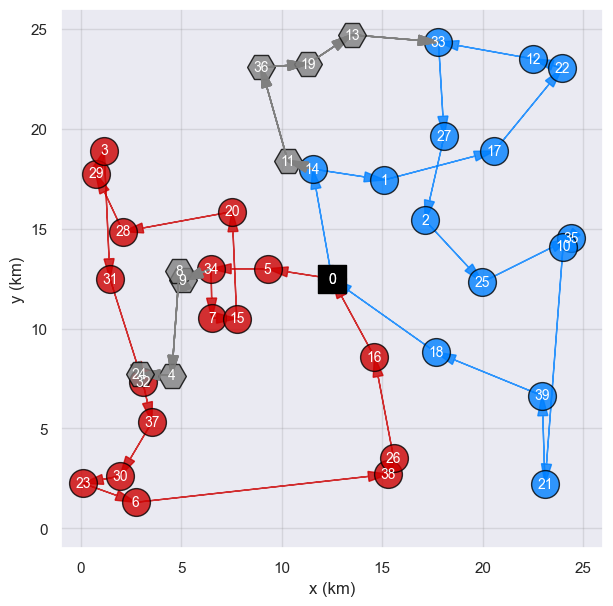

In [74]:
plot_map(routes=vrptw_routes, drone_routes=[], robot_routes=robot_routes, **controls)

### VRP + Drone + Robot

In [168]:
# VRP -> Robot -> VRPTW -> Drone
data = create_data_model(**controls)
routes = solve_routing_problem(data)
print(routes, '\n')
# robot routes
robot_routes = select_robot_nodes(data, routes)
# 調整車輛路線
for index, route in enumerate(routes):
    exclude_nodes = [item for sublist in robot_routes[index] for item in sublist if 0 < sublist.index(item) < len(sublist) - 1]
    routes[index] = [i for i in route if i not in exclude_nodes]
print('\nRoutes:', routes, '\n')

# VRPTW
robot_durs = [[] for i in range(len(routes))]

data["time_windows"] = [(0, 640) for i in range(data["num_nodes"])]

for index, group in enumerate(robot_routes):
    for r_route in group:
        r_dur = get_objective_value(data, r_route, ROBOT_SPEED) # 取得 robot_routes 中每個組合的時間
        print('Robot Route:', r_route, ', Duration:', r_dur)
        robot_durs[index].append(r_dur)
        for node in r_route:
            if 0 < r_route.index(node) < len(r_route) - 1:
                data['demands'][node] = 999  # 將指定點的需求設置為 999
                data["vehicle_capacities"][index] -= 1  # 修正該 node 負責車輛的容量
            
            # 頭尾設定 Time Windows (車輛不能等待超過 10 分鐘)          
            elif r_route.index(node) == 0:
                cumul_time = get_objective_value(data, routes[index][:routes[index].index(node)+1])
                node_tw = (0, cumul_time)
                data["time_windows"][node] = node_tw
                print('- Node', node, node_tw)
            elif r_route.index(node) == len(r_route) - 1:
                node_tw = (cumul_time + r_dur, cumul_time + r_dur + 10)
                data["time_windows"][node] = node_tw
                print('- Node', node, node_tw)

vrptw_routes = solve_vrptw(data)
robot_waiting = get_waiting_time(data, vrptw_routes, robot_routes, 'robot')

plot_map(routes=vrptw_routes, drone_routes=[], robot_routes=robot_routes, **controls)

Routes: [[0, 18, 23, 32, 13, 20, 15, 35, 17, 3, 4, 9, 34, 19, 5, 7, 11, 29, 36, 0], [0, 14, 10, 37, 27, 6, 1, 16, 8, 28, 12, 33, 22, 39, 21, 26, 25, 31, 38, 2, 30, 24, 0]], Length: 20
[[0, 18, 23, 32, 13, 20, 15, 35, 17, 3, 4, 9, 34, 19, 5, 7, 11, 29, 36, 0], [0, 14, 10, 37, 27, 6, 1, 16, 8, 28, 12, 33, 22, 39, 21, 26, 25, 31, 38, 2, 30, 24, 0]] 

Robot Routes: [[[0, 18, 23, 32, 13, 20]], [[10, 37, 27, 6, 1, 16], [26, 25, 31, 38, 2, 30]]]

Routes: [[0, 20, 15, 35, 17, 3, 4, 9, 34, 19, 5, 7, 11, 29, 36, 0], [0, 14, 10, 16, 8, 28, 12, 33, 22, 39, 21, 26, 30, 24, 0]] 

Robot Route: [0, 18, 23, 32, 13, 20] , Duration: 40
- Node 0 (0, 0)
- Node 20 (40, 50)
Robot Route: [10, 37, 27, 6, 1, 16] , Duration: 24
- Node 10 (0, 19)
- Node 16 (43, 53)
Robot Route: [26, 25, 31, 38, 2, 30] , Duration: 30
- Node 26 (0, 63)
- Node 30 (93, 103)


KeyError: 'nodes'

Drone Routes: [[[26, 27, 4], [31, 19, 1]], [[36, 12, 0], [20, 29, 28], [7, 11, 32], [32, 22, 3]]]

drone


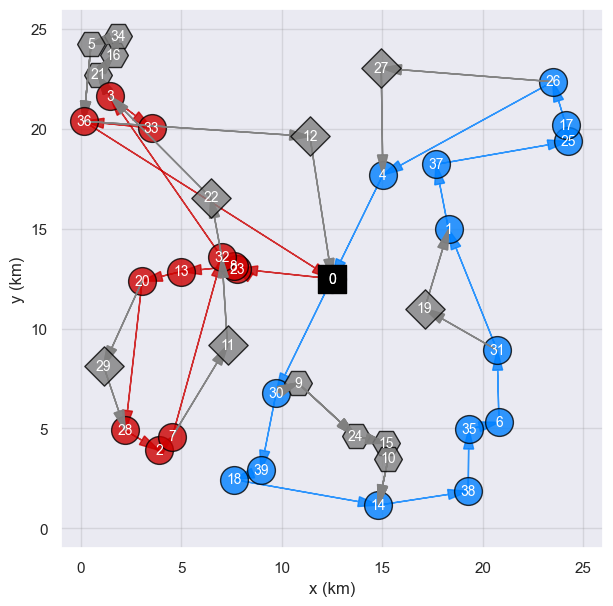

In [58]:
# drone routes
drone_routes = select_drone_nodes(data, vrptw_routes)
# 調整車輛路線
for index, group in enumerate(drone_routes):
    for r in group:
        vrptw_routes[index].remove(r[1])

drone_waiting = get_waiting_time(data, vrptw_routes, drone_routes, 'drone')

plot_map(routes=vrptw_routes, drone_routes=drone_routes, robot_routes=robot_routes, **controls)

In [91]:
def solve_by_VRPRD(data):
    start_time = time.time()
    tracemalloc.start()
    '''algorithm starts'''
    routes = solve_routing_problem(data)
    robot_routes = select_robot_nodes(data, routes)
    for index, route in enumerate(routes):
        exclude_nodes = [item for sublist in robot_routes[index] for item in sublist if 0 < sublist.index(item) < len(sublist) - 1]
        routes[index] = [i for i in route if i not in exclude_nodes]
    # VRPTW
    robot_durs = [[] for i in range(len(routes))]
    data["time_windows"] = [(0, 640) for i in range(data["num_nodes"])]
    for index, group in enumerate(robot_routes):
        for r_route in group:
            r_dur = get_objective_value(data, r_route, ROBOT_SPEED) # 取得 robot_routes 中每個組合的時間
            print('Robot Route:', r_route, ', Duration:', r_dur)
            robot_durs[index].append(r_dur)
            for node in r_route:
                if 0 < r_route.index(node) < len(r_route) - 1:
                    data['demands'][node] = 999  # 將指定點的需求設置為 999
                    data["vehicle_capacities"][index] -= 1  # 修正該 node 負責車輛的容量              
                # 頭尾設定 Time Windows (車輛不能等待超過 10 分鐘)          
                elif r_route.index(node) == 0:
                    cumul_time = get_objective_value(data, routes[index][:routes[index].index(node)+1])
                    node_tw = (0, cumul_time)
                    data["time_windows"][node] = node_tw
                    print('- Node', node, node_tw)
                elif r_route.index(node) == len(r_route) - 1:
                    node_tw = (cumul_time + r_dur, cumul_time + r_dur + 10)
                    data["time_windows"][node] = node_tw
                    print('- Node', node, node_tw)
    vrptw_routes = solve_vrptw(data)
    drone_routes = select_drone_nodes(data, vrptw_routes)
    for index, group in enumerate(drone_routes):
        for r in group:
            vrptw_routes[index].remove(r[1])
    robot_waiting = get_waiting_time(data, vrptw_routes, robot_routes, 'robot')
    drone_waiting = get_waiting_time(data, vrptw_routes, drone_routes, 'drone')
    total_dist, travel_time, waiting_time = get_travelling_time(data, vrptw_routes, drone_waiting, robot_waiting)
    '''algorithm ends'''
    end_time = time.time()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    time_complexity = round(end_time - start_time, 4)
    space_complexity = round(current / 1024, 4)
    VRPRD_result = dict(VRPRD_routes=vrptw_routes, VRPRD_distances=total_dist, VRPRD_time=travel_time, VRPRD_waiting=waiting_time, VRPRD_time_complexity=time_complexity, VRPRD_space_complexity=space_complexity)
    return VRPRD_result

In [110]:
data = create_data_model(**controls)
solve_by_VRP(data)

Routes: [[0, 1, 37, 25, 17, 26, 27, 4, 12, 3, 21, 16, 34, 5, 36, 33, 22, 32, 11, 0], [0, 23, 8, 13, 20, 29, 28, 7, 2, 18, 39, 30, 9, 24, 15, 10, 14, 38, 35, 6, 31, 19, 0]], Length: 20
Vehicle 0: 101 km, 101 mins
Vehicle 1: 86 km, 86 mins

Total distance of all routes: : 187 km
Maximum travel time: 101 mins


{'VRP_routes': [[0,
   1,
   37,
   25,
   17,
   26,
   27,
   4,
   12,
   3,
   21,
   16,
   34,
   5,
   36,
   33,
   22,
   32,
   11,
   0],
  [0,
   23,
   8,
   13,
   20,
   29,
   28,
   7,
   2,
   18,
   39,
   30,
   9,
   24,
   15,
   10,
   14,
   38,
   35,
   6,
   31,
   19,
   0]],
 'VRP_distances': 187,
 'VRP_time': 101,
 'VRP_waiting': 0,
 'VRP_time_complexity': 1.4871,
 'VRP_space_complexity': 1.7803}

## Main: 設定參數與記錄實驗結果

In [69]:
def create_result_model():
    
    result = {}    
    result["id"] = []
    result["map_size"] = []
    result["num_nodes"] = []
    result["num_locations"] = []
    result["num_vehicles"] = []
    result["vehicle_capacities"] = []
    # VRP
    result["VRP_routes"] = []
    result["VRP_distances"] = []
    result["VRP_time"] = []
    result["VRP_waiting"] = []
    result["VRP_time_complexity"] = []
    result["VRP_space_complexity"] = []
    # VRP-D
    result["VRPD_routes"] = []
    result["VRPD_drone_routes"] = []
    result["VRPD_distances"] = []
    result["VRPD_time"] = []
    result["VRPD_waiting"] = []
    result["VRPD_time_complexity"] = []
    result["VRPD_space_complexity"] = []
    # VRP-R
    result["VRPR_routes"] = []
    result["VRPR_robot_routes"] = []
    result["VRPR_distances"] = []
    result["VRPR_time"] = []
    result["VRPR_waiting"] = []
    result["VRPR_solved"] = []
    result["VRPR_time_complexity"] = []
    result["VRPR_space_complexity"] = []     
    # VRP-RD
    # result["VRPRD_routes"] = []
    # result["VRPRD_distances"] = []
    # result["VRPRD_time"] = []
    # result["VRPRD_waiting"] = []
    # result["VRPRD_solved"] = []
    # result["VRPRD_time_complexity"] = []
    # result["VRPRD_space_complexity"] = []
    return result

def solve_by_VRP(data):
    start_time = time.time()
    tracemalloc.start()
    '''algorithm starts'''
    routes = solve_routing_problem(data)
    total_dist, travel_time, waiting_time = get_travelling_time(data, routes)
    '''algorithm ends'''
    end_time = time.time()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    time_complexity = round(end_time - start_time, 4)
    space_complexity = round(current / 1024, 4)
    # print(f"Time taken: {time_complexity} seconds")
    # print(f"Memory used: {space_complexity} KB")
    VRP_result = dict(VRP_routes=routes, VRP_distances=total_dist, VRP_time=travel_time, VRP_waiting=waiting_time, VRP_time_complexity=time_complexity, VRP_space_complexity=space_complexity)
    return VRP_result

def solve_by_VRPD(data):
    start_time = time.time()
    tracemalloc.start()
    '''algorithm starts'''
    routes = solve_routing_problem(data)
    drone_routes = select_drone_nodes(data, routes)
    for index, group in enumerate(drone_routes):
        for r in group:
            routes[index].remove(r[1])
    drone_waiting = get_waiting_time(data, routes, drone_routes, 'drone')
    robot_waiting = [[] for i in range(len(drone_waiting))]
    total_dist, travel_time, waiting_time = get_travelling_time(data, routes, drone_waiting, robot_waiting)
    '''algorithm ends'''
    end_time = time.time()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    time_complexity = round(end_time - start_time, 4)
    space_complexity = round(current / 1024, 4)
    VRPD_result = dict(VRPD_routes=routes, VRPD_drone_routes=drone_routes, VRPD_distances=total_dist, VRPD_time=travel_time, VRPD_waiting=waiting_time, VRPD_time_complexity=time_complexity, VRPD_space_complexity=space_complexity)
    return VRPD_result

def solve_by_VRPR(data):
    start_time = time.time()
    tracemalloc.start()
    '''algorithm starts'''
    routes = solve_routing_problem(data)
    robot_routes = select_robot_nodes(data, routes)
    # 調整車輛路線
    for index, route in enumerate(routes):
        exclude_nodes = [item for sublist in robot_routes[index] for item in sublist if 0 < sublist.index(item) < len(sublist) - 1]
        routes[index] = [i for i in route if i not in exclude_nodes]
    # Set Time Windows
    robot_durs = [[] for i in range(len(routes))]

    data["time_windows"] = [(0, 640) for i in range(data["num_nodes"])]

    for index, group in enumerate(robot_routes):
        for r_route in group:
            r_dur = get_objective_value(data, r_route, ROBOT_SPEED) # 取得 robot_routes 中每個組合的時間
            print('Robot Route:', r_route, ', Duration:', r_dur)
            robot_durs[index].append(r_dur)
            for node in r_route:
                if 0 < r_route.index(node) < len(r_route) - 1:
                    data['demands'][node] = 999  # 將指定點的需求設置為 999
                    data["vehicle_capacities"][index] -= 1  # 修正該 node 負責車輛的容量
                
                # 頭尾設定 Time Windows (車輛不能等待超過 10 分鐘)          
                elif r_route.index(node) == 0:
                    cumul_time = get_objective_value(data, routes[index][:routes[index].index(node)+1])
                    node_tw = (0, cumul_time)
                    data["time_windows"][node] = node_tw
                    print('- Node', node, node_tw)
                elif r_route.index(node) == len(r_route) - 1:
                    node_tw = (cumul_time + r_dur, cumul_time + r_dur + 10)
                    data["time_windows"][node] = node_tw
                    print('- Node', node, node_tw)
    # Solve VRPTW
    vrptw_routes = solve_vrptw(data)
    robot_waiting = get_waiting_time(data, vrptw_routes, robot_routes, 'robot')
    drone_waiting = [[] for i in range(len(robot_waiting))]
    total_dist, travel_time, waiting_time = get_travelling_time(data, vrptw_routes, drone_waiting, robot_waiting)
    '''algorithm ends'''
    end_time = time.time()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    time_complexity = round(end_time - start_time, 4)
    space_complexity = round(current / 1024, 4)
    VRPR_result = dict(VRPR_routes=vrptw_routes, VRPR_drone_routes=drone_routes, VRPR_distances=total_dist, VRPR_time=travel_time, VRPR_waiting=waiting_time, VRPR_time_complexity=time_complexity, VRPR_space_complexity=space_complexity)
    return VRPR_result

# 地圖大小, 客戶點數量, 車輛數, 模擬次數
def simulate_experiment(**controls):

    for iter in range(1, controls["trials"]+1):
        
        print(f'Trial {iter}...')
        # 根據實驗變數建立 Model
        data = create_data_model(**controls)
        result["id"].append(len(result["id"])+1)
        result["map_size"].append((controls["map_size"][0], controls["map_size"][1]))
        result["num_nodes"].append(data["num_nodes"])
        result["num_locations"].append(data["num_locations"])
        result["num_vehicles"].append(data["num_vehicles"])
        result["vehicle_capacities"].append(data["vehicle_capacities"])
        # VRP
        VRP_result = solve_by_VRP(data)
        result["VRP_routes"].append(VRP_result["VRP_routes"])
        result["VRP_distances"].append(VRP_result["VRP_distances"])
        result["VRP_time"].append(VRP_result["VRP_time"])
        result["VRP_waiting"].append(VRP_result["VRP_waiting"])
        result["VRP_time_complexity"].append(VRP_result["VRP_time_complexity"])
        result["VRP_space_complexity"].append(VRP_result["VRP_space_complexity"])
        # VRP-D
        VRPD_result = solve_by_VRPD(data)
        result["VRPD_routes"].append(VRPD_result["VRPD_routes"])
        result["VRPD_drone_routes"].append(VRPD_result["VRPD_drone_routes"])
        result["VRPD_distances"].append(VRPD_result["VRPD_distances"])
        result["VRPD_time"].append(VRPD_result["VRPD_time"])
        result["VRPD_waiting"].append(VRPD_result["VRPD_waiting"])        
        result["VRPD_time_complexity"].append(VRPD_result["VRPD_time_complexity"])
        result["VRPD_space_complexity"].append(VRPD_result["VRPD_space_complexity"])
        # VRP-R

        # VRP-DR

    print('\nDone!')

In [101]:
# 記錄結果
result = create_result_model()

# 設定實驗參數 & 實驗
ex_controls = dict(map_size=(20, 20), num_nodes=10, num_vehicle=2, trials=10)
simulate_experiment(**ex_controls)

Trial 1...
Routes: [[0, 7, 1, 4, 5, 3, 6, 0], [0, 2, 9, 8, 0]], Length: 8
Routes: [[0, 7, 1, 4, 5, 3, 6, 0], [0, 2, 9, 8, 0]], Length: 8
Drone Routes: [[[0, 7, 1]], [[2, 9, 8]]]

drone
-Wait for: 4
-Wait for: 8
Trial 2...
Routes: [[0, 6, 9, 4, 2, 5, 1, 0], [0, 8, 7, 3, 0]], Length: 8
Routes: [[0, 6, 9, 4, 2, 5, 1, 0], [0, 8, 7, 3, 0]], Length: 8
Drone Routes: [[[5, 1, 0], [9, 4, 2]], [[7, 3, 0]]]

drone
-Wait for: 3
-Wait for: 2
Trial 3...
Routes: [[0, 6, 8, 3, 0], [0, 9, 4, 5, 2, 1, 7, 0]], Length: 5
Routes: [[0, 6, 8, 3, 0], [0, 9, 4, 5, 2, 1, 7, 0]], Length: 5
Drone Routes: [[[6, 8, 3]], [[2, 1, 7], [0, 9, 4]]]

drone
-Wait for: 3
-Wait for: 2
-Wait for: 3
Trial 4...
Routes: [[0, 7, 4, 6, 3, 0], [0, 2, 5, 8, 1, 9, 0]], Length: 6
Routes: [[0, 7, 4, 6, 3, 0], [0, 2, 5, 8, 1, 9, 0]], Length: 6
Drone Routes: [[[0, 7, 4]], [[8, 1, 9]]]

drone
-Wait for: 5
-Wait for: 2
Trial 5...
Routes: [[0, 7, 5, 4, 2, 8, 0], [0, 9, 3, 6, 1, 0]], Length: 7
Routes: [[0, 7, 5, 4, 2, 8, 0], [0, 9, 3, 6, 1,

In [102]:
pd.DataFrame(result).head()

,id,map_size,num_nodes,num_locations,num_vehicles,vehicle_capacities,VRP_routes,VRP_distances,VRP_time,VRP_waiting,VRP_time_complexity,VRP_space_complexity,VRPD_routes,VRPD_drone_routes,VRPD_distances,VRPD_time,VRPD_waiting,VRPD_time_complexity,VRPD_space_complexity
0,1,"(20, 20)",10,"[(10.0, 10.0), (15.37, 8.36), (8.43, 14.75), (...",2,"[6, 6]","[[0, 7, 1, 4, 5, 3, 6, 0], [0, 2, 9, 8, 0]]",91,60,0,0.1366,1.2607,"[[0, 1, 4, 5, 3, 6, 0], [0, 2, 8, 0]]","[[[0, 7, 1]], [[2, 9, 8]]]",66,55.0,12.0,0.1132,2.9883
1,2,"(20, 20)",10,"[(10.0, 10.0), (8.35, 17.58), (18.89, 9.35), (...",2,"[6, 6]","[[0, 6, 9, 4, 2, 5, 1, 0], [0, 8, 7, 3, 0]]",83,53,0,0.1450,1.0430,"[[0, 6, 9, 2, 5, 0], [0, 8, 7, 0]]","[[[5, 1, 0], [9, 4, 2]], [[7, 3, 0]]]",57,37.0,5.0,0.1557,2.1719
2,3,"(20, 20)",10,"[(10.0, 10.0), (17.68, 18.56), (19.9, 3.48), (...",2,"[6, 6]","[[0, 6, 8, 3, 0], [0, 9, 4, 5, 2, 1, 7, 0]]",101,67,0,0.1171,1.1133,"[[0, 6, 3, 0], [0, 4, 5, 2, 7, 0]]","[[[6, 8, 3]], [[2, 1, 7], [0, 9, 4]]]",64,46.0,8.0,0.1000,3.5195
3,4,"(20, 20)",10,"[(10.0, 10.0), (17.24, 16.19), (13.1, 11.02), ...",2,"[6, 6]","[[0, 7, 4, 6, 3, 0], [0, 2, 5, 8, 1, 9, 0]]",78,45,0,0.1194,1.3682,"[[0, 4, 6, 3, 0], [0, 2, 5, 8, 9, 0]]","[[[0, 7, 4]], [[8, 1, 9]]]",54,35.0,7.0,0.1287,1.4883
4,5,"(20, 20)",10,"[(10.0, 10.0), (13.56, 11.31), (5.34, 17.57), ...",2,"[6, 6]","[[0, 7, 5, 4, 2, 8, 0], [0, 9, 3, 6, 1, 0]]",89,46,0,0.1443,1.3359,"[[0, 7, 5, 2, 8, 0], [0, 3, 6, 1, 0]]","[[[5, 4, 2]], [[0, 9, 3]]]",61,42.0,12.0,0.1255,1.9258
